# DATA PREPARATION
### Merging

In [1]:
import pysal
import numpy
import scipy
import pandas
import shapefile as shp
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import preprocessing

%matplotlib inline
plt.style.use('ggplot')
pandas.set_option('display.max_rows', 100, "display.max_columns", 100)

In [2]:
db_blocks_groups = pysal.open('./dataset/Data/CLT_BlockGroups_Attr.dbf','r')
df_blocks_groups = pandas.DataFrame(db_blocks_groups[:], columns=db_blocks_groups.header)

db_blocks = pysal.open('./dataset/Data/CLT_Blocks_Attr.dbf','r')
df_blocks = pandas.DataFrame(db_blocks[:], columns=db_blocks.header)

db_business = pysal.open('./dataset/Data/CLT_Business_Attri.dbf','r')
df_business = pandas.DataFrame(db_business[:], columns=db_business.header)

db_crimes = pysal.open('./dataset/Data/CrimeIncident_CMPD_2010.dbf','r')
df_crimes = pandas.DataFrame(db_crimes[:], columns=db_crimes.header)

---
### Adding census stats 
Attaching related census stats for every block (when available)

In [6]:
# add column in crime dataframe for BLOCKID10 - taken from busine dataframe
# add "not found" where BLOCKID10 could not be found
street2block = df_business.set_index('ST_NAME')["Block_id"].to_dict()
df_crimes["BLOCKID10"] = df_crimes["Street_Nam"].map(lambda street: street2block.get(street, "not found"))
df_crimes.shape

(67595, 54)

In [7]:
# remove rows where BLOCKID10 is "not found"
df_crimes = df_crimes[df_crimes["BLOCKID10"] != "not found"]
df_crimes.shape

(50455, 54)

In [8]:
# adding df_blocks' and df_blocks_groups' columns of interest
census = {}
for index, row in df_blocks_groups.iterrows():
    census[str(row["GEOID10"])] = {
        "ARPCIncome": row["ARPCIncome"],
        "ARPerHEdu":  row["ARPerHEdu"],
        "ARPerWork":  row["ARPerWork"],
        "ARPerRMI5L": row["ARPerRMI5L"],
        "ARPer3MU":   row["ARPer3MU"]}

for index, row in df_blocks.iterrows():
    census[str(row["BLOCKID10"])] = {
        "ARPopDen":   row["ARPopDen"],
        "ARPerAA":    row["ARPerAA"],
        "ARHeteInx":  row["ARHeteInx"],
        "ARPerM1724": row["ARPerM1724"],
        "ARPerHOwn":  row["ARPerHOwn"],
        "ARPerSF":    row["ARPerSF"]}

    
get_group_census = lambda col: lambda block_id: census.get(block_id[0:12], {}).get(col, "NF")
get_block_census = lambda col: lambda block_id: census.get(block_id, {}).get(col, "NF")

df_crimes["ARPCIncome"] = df_crimes["BLOCKID10"].map(get_group_census("ARPCIncome"))
df_crimes["ARPerHEdu"]  = df_crimes["BLOCKID10"].map(get_group_census("ARPerHEdu"))
df_crimes["ARPerWork"]  = df_crimes["BLOCKID10"].map(get_group_census("ARPerWork"))
df_crimes["ARPerRMI5L"] = df_crimes["BLOCKID10"].map(get_group_census("ARPerRMI5L"))
df_crimes["ARPer3MU"]   = df_crimes["BLOCKID10"].map(get_group_census("ARPer3MU"))

df_crimes["ARPopDen"]   = df_crimes["BLOCKID10"].map(get_block_census("ARPopDen"))
df_crimes["ARPerAA"]    = df_crimes["BLOCKID10"].map(get_block_census("ARPerAA"))
df_crimes["ARHeteInx"]  = df_crimes["BLOCKID10"].map(get_block_census("ARHeteInx"))
df_crimes["ARPerM1724"] = df_crimes["BLOCKID10"].map(get_block_census("ARPerM1724"))
df_crimes["ARPerHOwn"]  = df_crimes["BLOCKID10"].map(get_block_census("ARPerHOwn"))
df_crimes["ARPerSF"]    = df_crimes["BLOCKID10"].map(get_block_census("ARPerSF"))

df_crimes.shape

(50455, 65)

In [9]:
# removing all rows that don't have census attributes
# because some BLOCKID10 don't exists in df_blocks and df_block_groups
df_temp = df_crimes[df_crimes["ARPopDen"] != "NF"]
df_crimes_and_census = df_temp[df_temp["ARPCIncome"] != "NF"]
df_crimes_and_census.shape

(19106, 65)

---
### Adding nearest K POI

In [10]:
# find nearest n business/POI for a crime
crime_points    = numpy.array(pysal.open('./dataset/Data/CrimeIncident_CMPD_2010.shp', 'r'))
business_points = numpy.array(pysal.open('./dataset/Data/CLT_Business_Attri.shp', 'r'))
mall_points     = numpy.array(pysal.open('./dataset/Data/POI_Malls.shp', 'r'))
walmart_points  = numpy.array(pysal.open("./dataset/Data/POI_WALMART.shp", 'r'))
drinking_points = numpy.array(pysal.open("./dataset/Data/POI_AlcoholicDrinkingPlaces_CLIP.shp", 'r'))
hotels_points   = numpy.array(pysal.open("./dataset/Data/POI_HotelsMotels.shp", 'r'))
park_points     = numpy.array(pysal.open("./dataset/Data/POI_ParknRideFacilities.shp", 'r'))

business_name = [row["TradeName"] for i, row in df_business.iterrows()]
mall_name     = ["mall" for i in mall_points]
walmart_name  = ["walmart" for i in walmart_points]
drinking_name = ["drinking" for i in drinking_points]
hotels_name   = ["hotels" for i in hotels_points]
park_name     = ["park" for i in park_points]

names  = business_name + mall_name + walmart_name + drinking_name + hotels_name + park_name
points = numpy.concatenate((business_points, mall_points, walmart_points,
                            drinking_points, hotels_points, park_points))

In [11]:
# closest_POI -> for each crime its neighbourhood
closest_POI = []
k_closest = 4
kd_tree = scipy.spatial.cKDTree(points, leafsize=100)
for point in crime_points:
    neighborhood = kd_tree.query(point, k=k_closest)
    closest_POI.append( [str(names[neighbor]) for neighbor in neighborhood[1]] )


In [12]:
# adding closestPOI to df 
for i, row in df_crimes_and_census.iterrows():
    df_crimes_and_census.set_value(i,'First_POI', closest_POI[i][0])
    df_crimes_and_census.set_value(i,'Second_POI', closest_POI[i][1])
    df_crimes_and_census.set_value(i,'Third_POI', closest_POI[i][2])
    df_crimes_and_census.set_value(i,'Fourth_POI', closest_POI[i][3])

---
###  Removing useless columns

In [13]:
# keeping only some crimes' columns
col2keep = [
    "BLOCKID10",    # block ID
    "First_POI",    # first closest POI
    "Second_POI",   # second closest POI
    "Third_POI",    # third closest POI
    "Fourth_POI",   # fourth closest POI
    "ARPCIncome",   # percapital Income; type: real, length 18
    "ARPerHEdu",    # percentage of education with high school and above
    "ARPerWork",    # percentage of population employed
    "ARPerRMI5L",   # percentage of population who rent and moved in less than 5 years ago
    "ARPer3MU",     # percentage of home with 3 or more multiple unit structure
    "ARPopDen",     # population density; type: real, length 18
    "ARPerAA",      # percentage of population who are American African
    "ARHeteInx",    # heterogeneity index for races
    "ARPerM1724",   # percentage of population who are 17-24 males
    "ARPerHOwn",    # percentage of population who own home
    "ARPerSF",      # percentage of families with single parent
    "NIBRSclass",   # type of crime i guess
    "Attempt",      # completed, ecc
    "Case_Statu",   # further investigation, close/cleared, ecc
    "Clearance_",   # open, normal clearance/cleared by arrest, ecc
    "Place1",       # residential, open area, commercial place, retail
    "Place2",       # private residence, street/highway, ecc
    "Location_T",   # indoors or outdoors
    "Report_Dat",   # date
    "Street_Nam"    # street
]

# 19106 rows × 25 columns
df_crimes_and_census = df_crimes_and_census[col2keep]
df_crimes_and_census.shape

(19106, 25)

In [14]:
df_crimes_and_census[:3]

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
0,371190032011003,CHARLOTTE WOOD APARTMENTS,CAROLINA FIRST AID & SAFETY,WILDWOOD APARTMENTS,MT ZION HOLINESS CHURCH,23826,22.5136,93.0147,30.6122,20.3501,0.000151339,7.42574,0.549505,8.91089,14,38,Simple Assault,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Residential,Apartment/Duplex Private Res,Indoors,01/01/2010 0005,SCALEYBARK
12,371190015041006,UNITED TREATMENT FACILITY,LINKS AT CITI SIDE,STRAIGHT LINE PAVEMENT MARKING,JAMES D MCDUFFIE AGENT,17393,14.6895,80.3054,28.8553,28.1577,0.00013986,54.1667,0.53125,0,72.7273,36.3636,Simple Assault,Completed,Close/Cleared,Exceptionally Cleared - Victim Chose not to Pr...,Residential,Apartment/Duplex Private Res,Outdoors,01/01/2010 0110,CITISIDE
15,371190001001020,hotels,ILLUM'E,OMNI CHARLOTTE HOTEL,THE RITZ CARLTON HOTEL COMPANY LLC,106794,3.0888,100,74.4681,88.9145,0,0,0,0,0,0,Weapon Law Violations,Completed,Close/Cleared,Normal Clearance - Cleared by Arrest,Open Area,Street/Highway,Outdoors,01/01/2010 0118,COLLEGE


In the following we show some simple statistic about each variable:
- **Count**: Describes the number of not null values;
- **Unique**: Describes the number of unique values;
- **Top**: Describes the mode (in the case of multiple mode only one is shown)
- **Freq**: Describe the frequency of the returned top value


In [15]:
df_crimes_and_census.describe()

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
count,19106,19106,19106,19106,19106,19106.0,19106.000000,19106.000000,19106.000000,19106.0,19106.0,19106.0,19106.0,19106.0,19106.0,19106.0,19106,19106,19106,19106,19106,19106,19106,19106,19106
unique,741,3798,3895,4165,4292,181.0,180.000000,180.000000,168.000000,153.0,623.0,385.0,463.0,287.0,297.0,275.0,52,2,4,10,5,67,5,18673,1094
top,371190047001015,MARMI,hotels,CARLYLE & COMPANY,LIZ CLAIBORNE,18560.0,13.170732,71.957295,36.824697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Theft From Motor Vehicle,Completed,Inactive,Open,Residential,Private Residence,Indoors,05/01/2010 1631,TRADE
freq,787,215,311,215,215,1058.0,1058.000000,1058.000000,1058.000000,1591.0,5727.0,7570.0,7663.0,9086.0,6868.0,7044.0,2523,18413,9803,11520,8414,3950,8451,3,787


---

### Discretize

In [17]:
df = df_crimes_and_census.copy()
df["ARPCIncome"] = pandas.qcut(df_crimes_and_census["ARPCIncome"], 5, 
                        labels=["inc_low", "inc_midlow", "inc_mid", "inc_midhigh", "inc_high"])
df["ARPerHEdu"]  = pandas.qcut(df_crimes_and_census["ARPerHEdu"], 5, 
                        labels=["edu_low", "edu_midlow", "edu_mid", "edu_midhigh", "edu_high"])
df["ARPerWork"]  = pandas.qcut(df_crimes_and_census["ARPerWork"], 5, 
                        labels=["empl_low", "empl_midlow", "empl_mid", "empl_midhigh", "empl_high"])
df["ARPerRMI5L"] = pandas.qcut(df_crimes_and_census["ARPerRMI5L"], 5, 
                        labels=["lt5y_low", "lt5y_midlow", "lt5y_mid", "lt5y_midhigh", "lt5y_high"])
df["ARPer3MU"]   = pandas.qcut(df_crimes_and_census["ARPer3MU"], 5, 
                        labels=["3mu_low", "3mu_midlow", "3mu_mid", "3mu_midhigh", "3mu_high"])


df["ARPopDen"]   = pandas.qcut(df_crimes_and_census["ARPopDen"].replace(0, numpy.nan), 5, 
                        labels=["popden_low", "popden_midlow", "popden_mid", "popden_midhigh", "popden_high"])
df["ARPerAA"]    = pandas.qcut(df_crimes_and_census["ARPerAA"].replace(0, numpy.nan), 5, 
                        labels=["afro_low", "afro_midlow", "afro_mid", "afro_midhigh", "afro_high"])
df["ARHeteInx"]  = pandas.qcut(df_crimes_and_census["ARHeteInx"].replace(0, numpy.nan), 5, 
                        labels=["hetero_low", "hetero_midlow", "hetero_mid", "hetero_midhigh", "hetero_high"])
df["ARPerM1724"] = pandas.qcut(df_crimes_and_census["ARPerM1724"].replace(0, numpy.nan), 5, 
                        labels=["youngm_low", "youngm_midlow", "youngm_mid", "youngm_midhigh", "youngm_high"])
df["ARPerHOwn"]  = pandas.qcut(df_crimes_and_census["ARPerHOwn"].replace(0, numpy.nan), 5, 
                        labels=["own_low", "own_midlow", "own_mid", "own_midhigh", "own_high"])
df["ARPerSF"]    = pandas.qcut(df_crimes_and_census["ARPerSF"].replace(0, numpy.nan), 5, 
                        labels=["sinpar_low", "sinpar_midlow", "sinpar_mid", "sinpar_midhigh", "sinpar_high"])


In [18]:
# removing last 5 digits from Report_Dat
for i, row in df.iterrows():
    df.set_value(i,'Report_Dat', row["Report_Dat"][:-5])

In [19]:
df.describe()

,BLOCKID10,First_POI,Second_POI,Third_POI,Fourth_POI,ARPCIncome,ARPerHEdu,ARPerWork,ARPerRMI5L,ARPer3MU,ARPopDen,ARPerAA,ARHeteInx,ARPerM1724,ARPerHOwn,ARPerSF,NIBRSclass,Attempt,Case_Statu,Clearance_,Place1,Place2,Location_T,Report_Dat,Street_Nam
count,19106,19106,19106,19106,19106,19106,19106,19106,19106,19106,13379,11536,11443,10020,12238,12062,19106,19106,19106,19106,19106,19106,19106,19106,19106
unique,741,3798,3895,4165,4292,5,5,5,5,5,5,5,5,5,5,5,52,2,4,10,5,67,5,365,1094
top,371190047001015,MARMI,hotels,CARLYLE & COMPANY,LIZ CLAIBORNE,inc_low,edu_low,empl_midlow,lt5y_midlow,3mu_midhigh,popden_low,afro_midhigh,hetero_midlow,youngm_mid,own_mid,sinpar_midhigh,Theft From Motor Vehicle,Completed,Inactive,Open,Residential,Private Residence,Indoors,05/06/2010,TRADE
freq,787,215,311,215,215,4097,4195,4069,4494,3987,3148,3056,2330,2179,2597,2509,2523,18413,9803,11520,8414,3950,8451,81,787


---
### Missing Values

In [20]:
df[["ARPopDen", "ARPerAA", "ARHeteInx", "ARPerM1724", "ARPerHOwn", "ARPerSF"]][:3].style.applymap(
    lambda val: 'color: %s' % ('red' if val != val else 'black'))

In [21]:
# predicting NaN values for {ARPopDen - ARPerAA - ARHeteInx - ARPerM1724 - ARPerHOwn - ARPerSF}
# using all other columns
columns_without_mv = [
    "BLOCKID10",    # block ID
    "First_POI",    # first closest POI
    "Second_POI",   # second closest POI
    "Third_POI",    # third closest POI
    "Fourth_POI",   # fourth closest POI
    "ARPCIncome",   # percapital Income; type: real, length 18
    "ARPerHEdu",    # percentage of education with high school and above
    "ARPerWork",    # percentage of population employed
    "ARPerRMI5L",   # percentage of population who rent and moved in less than 5 years ago
    "ARPer3MU",     # percentage of home with 3 or more multiple unit structure
    "NIBRSclass",   # type of crime i guess
    "Attempt",      # completed, attempted
    "Case_Statu",   # further investigation, close/cleared, ecc
    "Clearance_",   # open, normal clearance/cleared by arrest, ecc
    "Place1",       # residential, open area, commercial place, retail
    "Place2",       # private residence, street/highway, ecc
    "Location_T",   # indoors or outdoors
    "Report_Dat",   # date
    "Street_Nam"    # street
]

In [22]:
%%time

values_set = set()
for col in df:
    for elem in df[col].unique():
        values_set.add(elem)

encoder = preprocessing.LabelEncoder()
encoder.fit(list(values_set))

for col_to_predict in ["ARPopDen", "ARPerAA", "ARHeteInx", "ARPerM1724", "ARPerHOwn", "ARPerSF"]:
    sample_df = df[columns_without_mv + [col_to_predict]]
    sample_df.dropna(subset=[col_to_predict], inplace=True)
    
    target = encoder.transform(sample_df[col_to_predict].tolist())
    sample_df = sample_df.drop(col_to_predict, axis=1)
    samples = [encoder.transform(row.tolist()) for i, row in sample_df.iterrows()]
#     print len(samples[0]), len(target)
    
    classifier = tree.DecisionTreeClassifier()
    classifier.fit(samples, target)
    
    for i, row in df.iterrows():
        if row[col_to_predict] != row[col_to_predict]: # check if is NaN
            prediction_encoded = classifier.predict([encoder.transform(row[columns_without_mv].tolist())])
            prediction_decoded = encoder.inverse_transform(prediction_encoded)
            df.set_value(i, col_to_predict, prediction_decoded)
    


/home/chris/.anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 12min 44s, sys: 600 ms, total: 12min 45s
Wall time: 12min 45s


---
### Some fancy plot
very nice indeed

Crimes aggregated every ten days


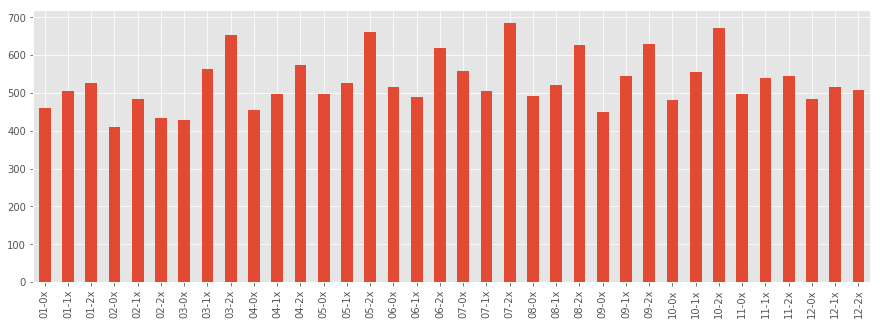

In [23]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size

date_series = df["Report_Dat"].astype('category')
date_series = date_series.value_counts().sort_index()

crime_per_month = {}
for key, val in date_series.iteritems():
    month = key[:2]
    day = key[3:4]
    k = month + "-" + ("2" if int(day) == 3 else str(day)) + "x"
    crime_per_month[k] = crime_per_month.get(k, 0) + val

pandas.Series(crime_per_month).plot.bar()
print "Crimes aggregated every ten days"

Places


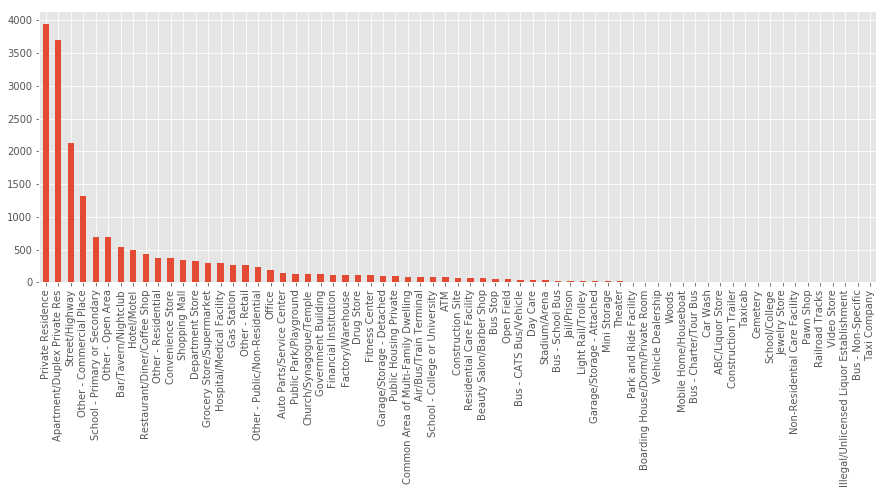

In [24]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size

crime_place = df["Place2"].astype('category')
crime_place.value_counts().plot.bar()
print "Places"

Class


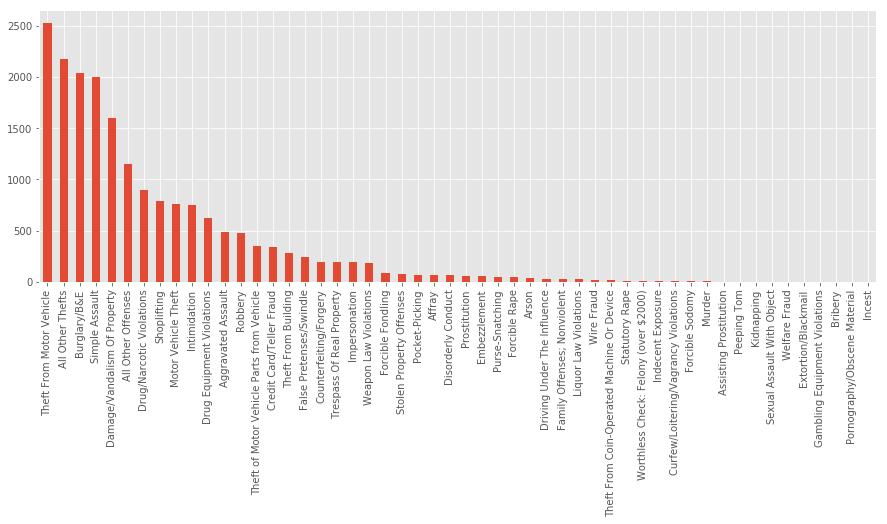

In [25]:
fig_size = [15, 5]
plt.rcParams["figure.figsize"] = fig_size

crime_class = df["NIBRSclass"].astype('category')
crime_class.value_counts().plot.bar()
print "Class"

In [26]:
df.to_csv("dataset/prova.csv", sep='\t')